# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

## **Executive Summary**  
### This project applies machine learning to the SECOM semiconductor manufacturing dataset (590 sensor readings, 1,567 runs) to predict wafer failures. The dataset is highly imbalanced (≈6.6% fails). Logistic Regression and MLP provide the strongest baselines (PR-AUC ≈0.17), while tree-based models underperform. Dimensionality reduction (PCA) reduced accuracy, highlighting the challenge of rare-event prediction in high-dimensional, noisy process data.

## Dataset Information
```
Additional Information

A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

To enhance current business improvement techniques the application of feature selection as an intelligent systems technique is being investigated.

The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.


Using feature selection techniques it is desired to rank features according to their impact on the overall yield for the product, causal relationships may also be considered with a view to identifying the key features.

Results may be submitted in terms of feature relevance for predictability using error rates as our evaluation metrics. It is suggested that cross validation be applied to generate these results. Some baseline results are shown below for basic feature selection techniques using a simple kernel ridge classifier and 10 fold cross validation.

Baseline Results: Pre-processing objects were applied to the dataset simply to standardize the data and remove the constant features and then a number of different feature selection objects selecting 40 highest ranked features were applied with a simple classifier to achieve some initial results. 10 fold cross validation was used and the balanced error rate (*BER) generated as our initial performance metric to help investigate this dataset.


SECOM Dataset: 1567 examples 591 features, 104 fails

FSmethod (40 features) BER % True + % True - %
S2N (signal to noise) 34.5 +-2.6 57.8 +-5.3 73.1 +2.1
Ttest 33.7 +-2.1 59.6 +-4.7 73.0 +-1.8
Relief 40.1 +-2.8 48.3 +-5.9 71.6 +-3.2
Pearson 34.1 +-2.0 57.4 +-4.3 74.4 +-4.9
Ftest 33.5 +-2.2 59.1 +-4.8 73.8 +-1.8
Gram Schmidt 35.6 +-2.4 51.2 +-11.8 77.5 +-2.3

Has Missing Values?

Yes
```

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 300,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Data directory
DATA_DIR = Path("../data")
RAW = DATA_DIR
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missong!"

# Results directory
RESULT_DIR = Path("../results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

#### Numbering continue from 01_EDA.ipynb

### 5. Extract Transform Load (ETL)

In [2]:
# Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [3]:
# Load data from EDA step.
df_EDA = pd.read_parquet(DATA_DIR/"interim/SECOM_EDA.parquet")
df = df_EDA.copy()
df = df.drop(columns=["timestamp"])  # timestamp not needed for modeling

#### 5.1. Missing value handling (audit + strategy)

From EDA we know:
- Most features have almost no missing values.
- A few have extreme missingness (up to `~91%`).
- Average missingness `~4.5%`.

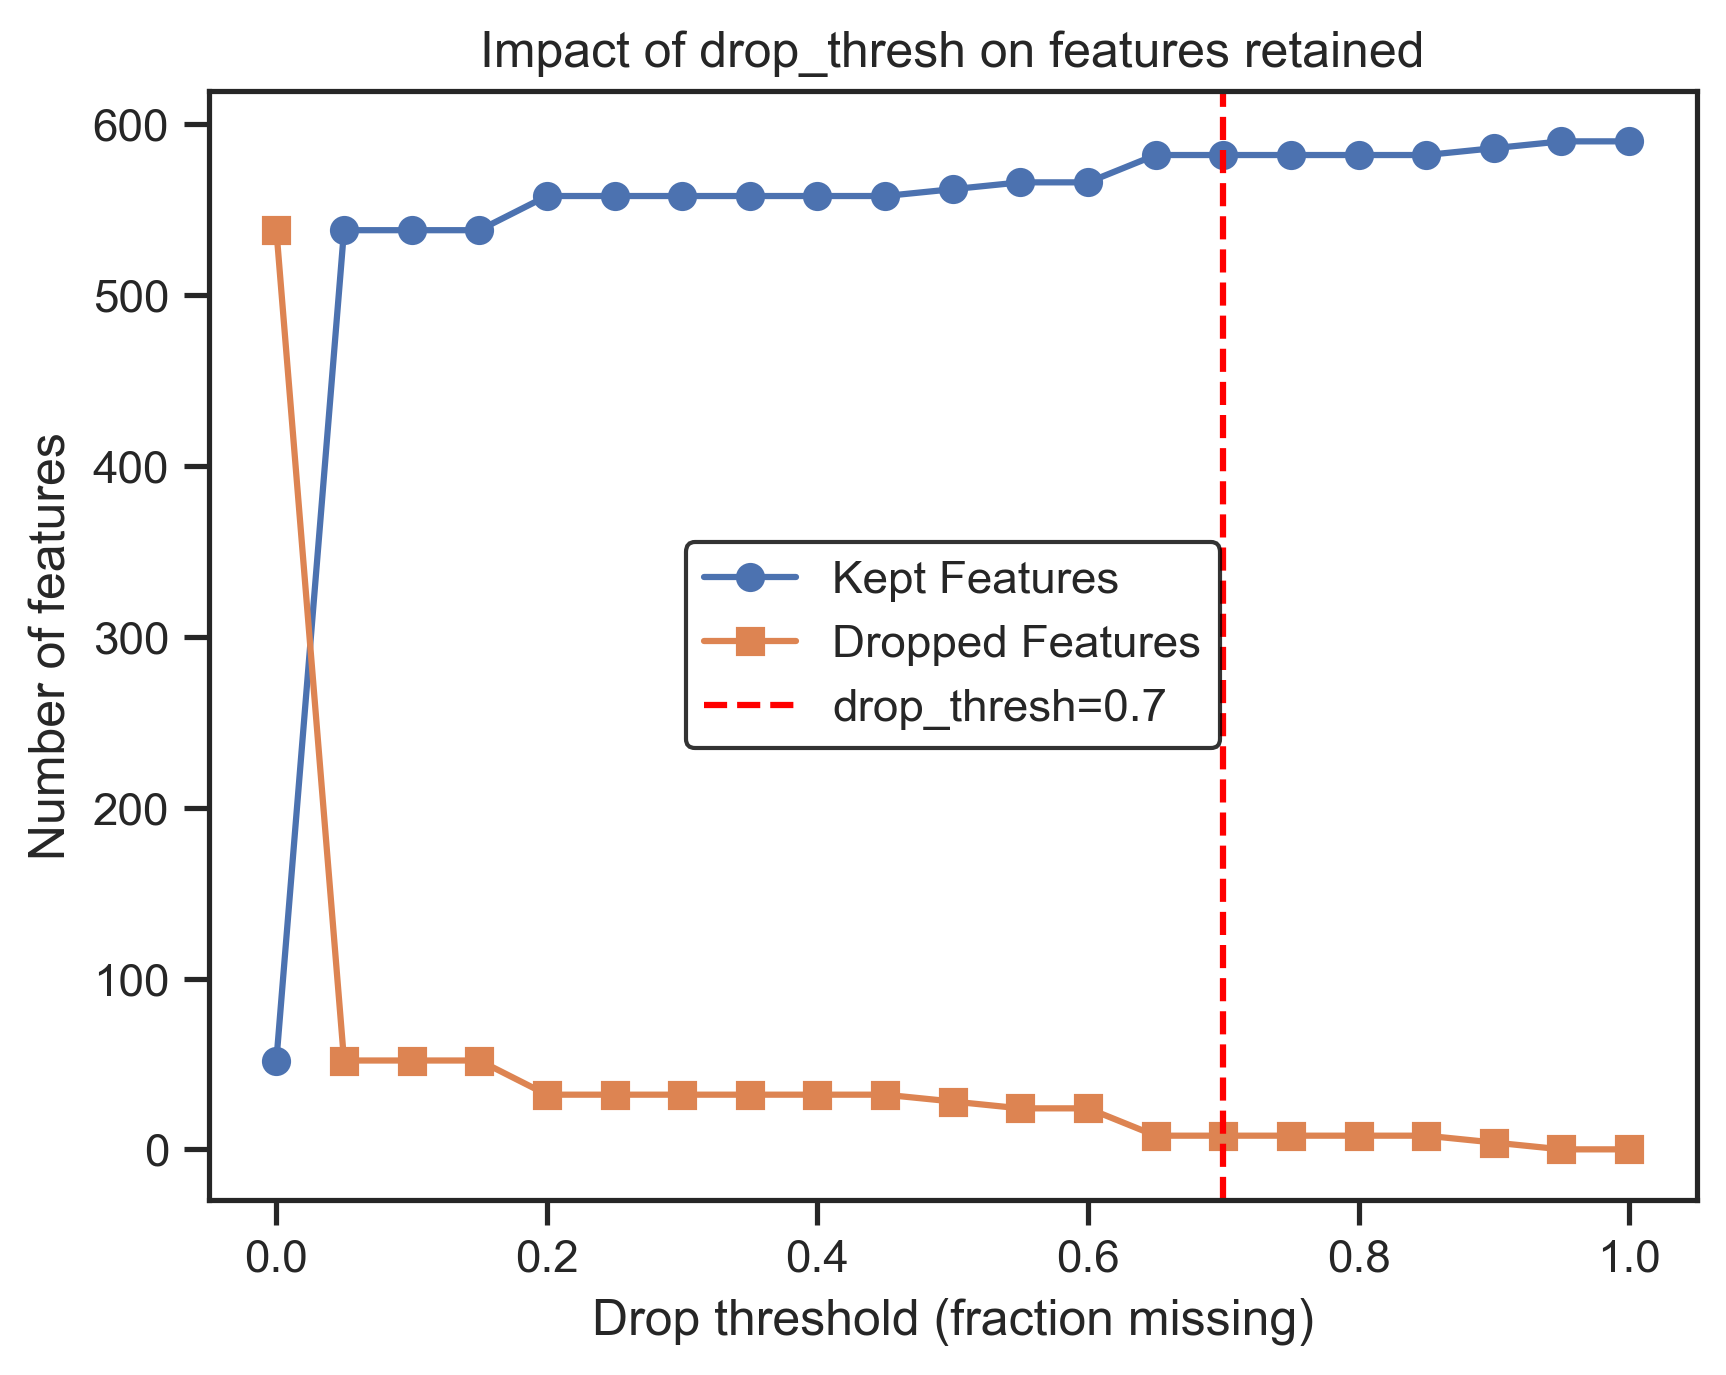

In [4]:
# Fraction of missing per feature
missing_frac = df.drop(columns=["label"]).isna().mean()

# Candidate thresholds to test
thresh_values = np.linspace(0, 1, 21)

kept, dropped = [], []

for t in thresh_values:
    drop_cols = (missing_frac > t).sum()
    keep_cols = (missing_frac <= t).sum()
    dropped.append(drop_cols)
    kept.append(keep_cols)

plt.plot(thresh_values, kept, marker="o", label="Kept Features")
plt.plot(thresh_values, dropped, marker="s", label="Dropped Features")
plt.axvline(0.7, color="red", linestyle="--", label="drop_thresh=0.7")
plt.xlabel("Drop threshold (fraction missing)")
plt.ylabel("Number of features")
plt.title("Impact of drop_thresh on features retained")
plt.legend()
plt.show()

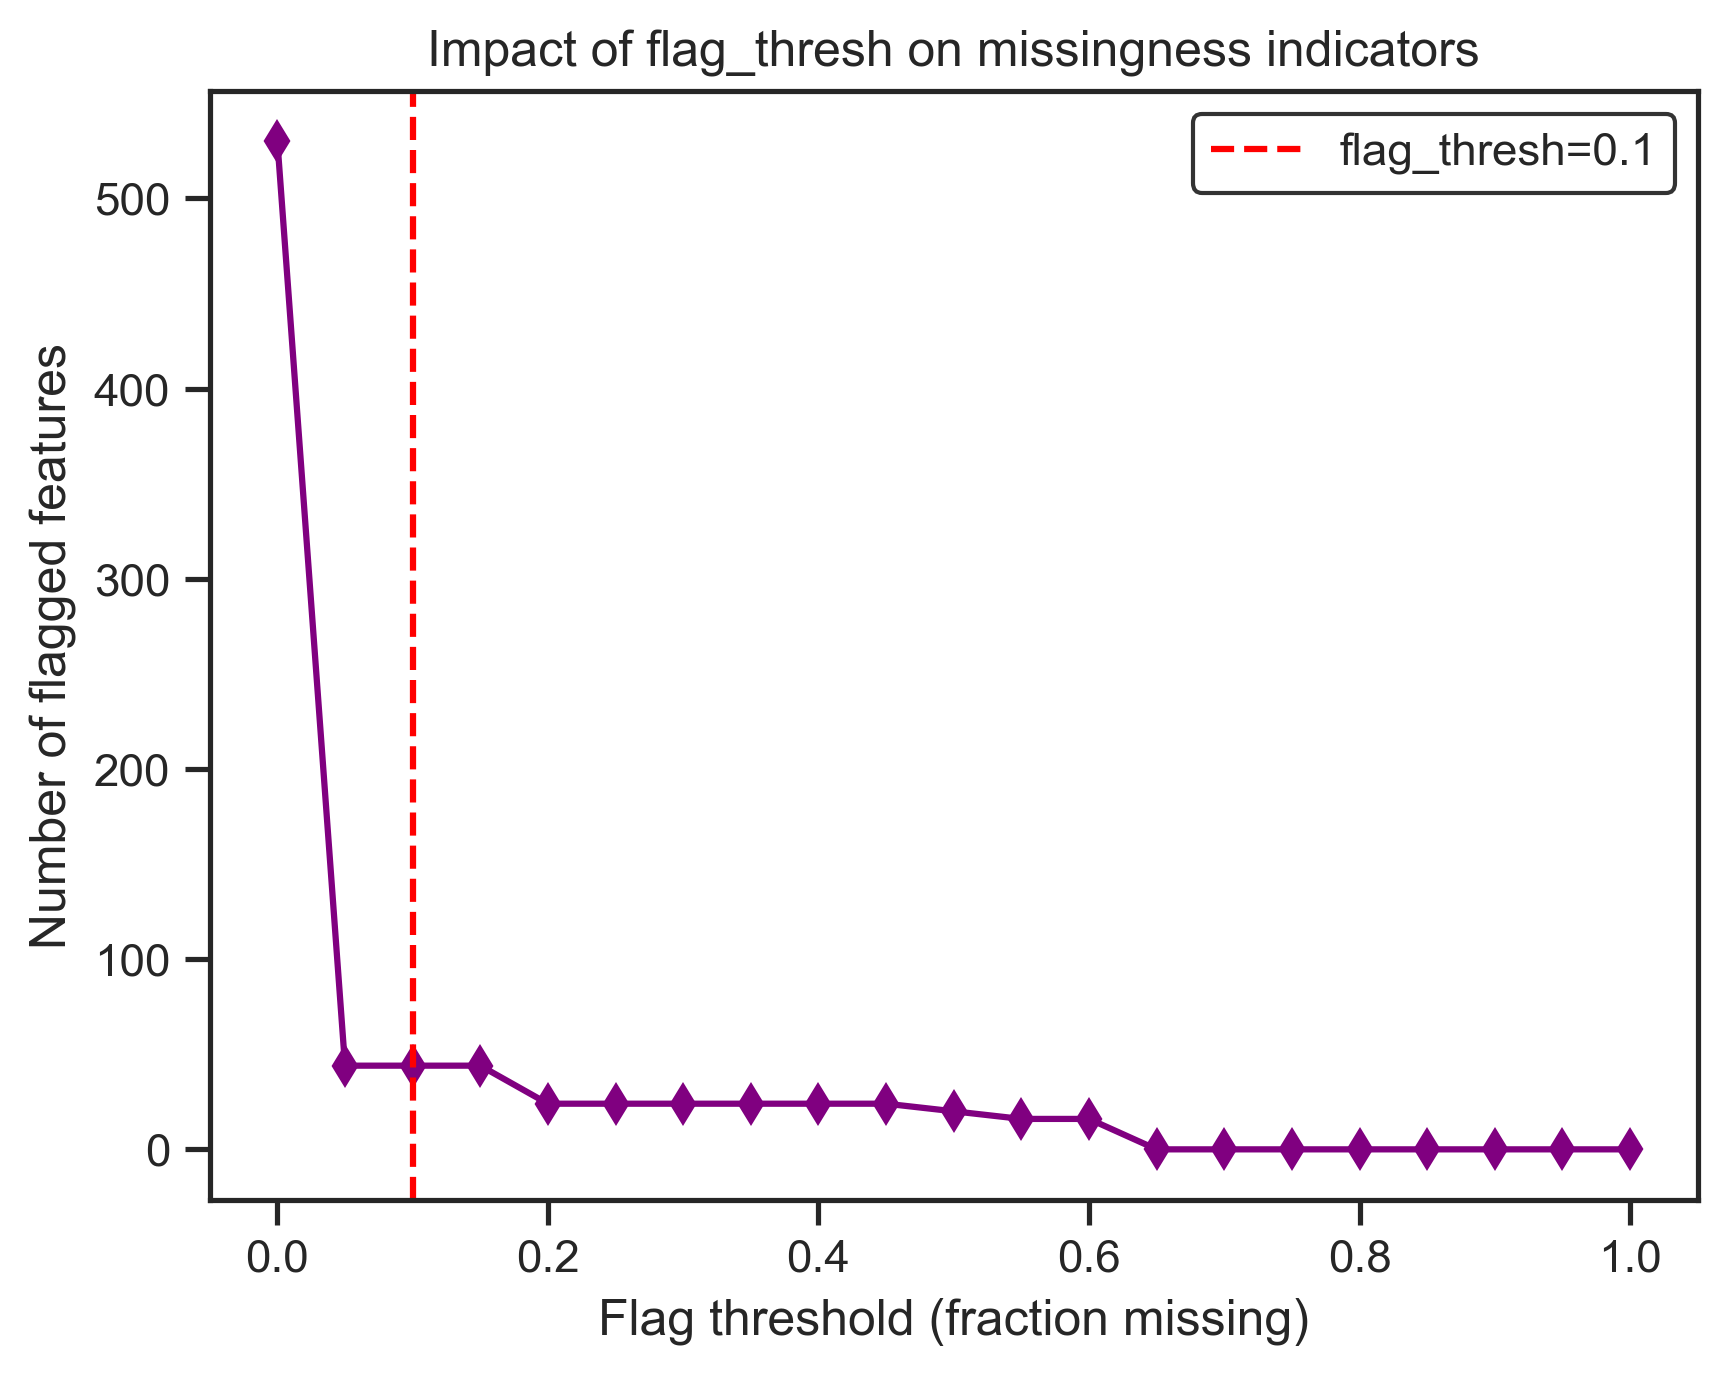

In [5]:
flag_counts = []
for t in thresh_values:
    flag_cols = ((missing_frac > t) & (missing_frac <= 0.7)).sum()
    flag_counts.append(flag_cols)

plt.plot(thresh_values, flag_counts, marker="d", color="purple")
plt.axvline(0.1, color="red", linestyle="--", label="flag_thresh=0.1")
plt.xlabel("Flag threshold (fraction missing)")
plt.ylabel("Number of flagged features")
plt.title("Impact of flag_thresh on missingness indicators")
plt.legend()
plt.show()

In [6]:
# 1. Audit missingness (from EDA)
print(missing_frac.describe())

# 2. Define thresholds
drop_thresh = 0.7   # drop if >70% missing
flag_thresh = 0.1   # add missing indicator if >10% missing

# 3. Identify feature groups
drop_cols = missing_frac[missing_frac > drop_thresh].index.tolist()
flag_cols = missing_frac[(missing_frac > flag_thresh) & (missing_frac <= drop_thresh)].index.tolist()
keep_cols = missing_frac[missing_frac <= drop_thresh].index.tolist()

print(f"Drop {len(drop_cols)} features with >70% missing")
print(f"Flag {len(flag_cols)} features with 10-70% missing")
print(f"Keep {len(keep_cols)} features with <70% missing")

# 4. Drop high-missing features
df_etl = df.drop(columns=drop_cols)

# 5. Add missingness indicators
for col in flag_cols:
    df_etl[col+"_missing"] = df_etl[col].isna().astype(int)

# 6. Impute remaining missing with median
imputer = SimpleImputer(strategy="median")
df_etl[keep_cols] = imputer.fit_transform(df_etl[keep_cols])

print("Shape:", df_etl.shape)

count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64
Drop 8 features with >70% missing
Flag 44 features with 10-70% missing
Keep 582 features with <70% missing
Shape: (1567, 627)


#### Interpretation:
- `590` features were checked for missingness.
- `8` features had more than `70%` missing values, so dropped as too sparse to be useful.
- `44` features had `10–70%` missing values, retained but each got a binary missingness indicator column (so models can learn if “missingness” itself carries signal).
- `582` features had less than `70%` missing values: median-imputed.
- After adding indicators, the dataset grew to `627` features total.

#### 5.2. Outlier Handling.

In [7]:
from scipy.stats import skew

strategies = {}
X = df_etl.drop(columns="label")

for col in X.columns:
    s = X[col].dropna()
    sk = skew(s)
    if abs(sk) > 1 and (s >= 0).all():
        strategies[col] = "log"
    elif s.quantile(0.99) > s.quantile(0.5) * 5:  # extreme tail
        strategies[col] = "winsor"
    else:
        strategies[col] = "keep"

# Summary of counts
from collections import Counter
print(Counter(strategies.values()))

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_9810/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_9810/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_9810/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_9810/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the d

Counter({'log': 325, 'keep': 262, 'winsor': 39})


In [8]:
# Helper functions for outlier handling.
def winsorize_col(s: pd.Series, lower=0.01, upper=0.99):
    """Clip to [lower, upper] quantiles. Works with NaNs."""
    ql, qu = s.quantile(lower), s.quantile(upper)
    return s.clip(lower=ql, upper=qu)

def apply_outlier_transforms(df_in: pd.DataFrame,
                             strategies: dict,
                             winsor=(0.01, 0.99),
                             log_safe=True) -> pd.DataFrame:
    """
    Apply per-column outlier strategy:
        'log'     -> log1p (if non-negative; else fallback to winsor)
        'winsor'  -> clip to quantiles
        'keep'    -> no change
    Non-feature columns like 'label' are passed through unchanged.
    """
    df = df_in.copy()
    feat_cols = [c for c in df.columns if c != "label"]

    # Summary counters
    n_log = n_win = n_keep = n_badlog = 0

    for c in feat_cols:
        strat = strategies.get(c, "keep")

        # Choose action
        if strat == "log":
            s = df[c]
            # If any negatives and log_safe, fallback to winsor
            if log_safe and (s.min(skipna=True) < 0):
                df[c] = winsorize_col(s, *winsor)
                n_badlog += 1; n_win += 1
            else:
                # log1p handles zeros; keep NaNs as-is (assumed imputed earlier)
                df[c] = np.log1p(s)
                n_log += 1

        elif strat == "winsor":
            df[c] = winsorize_col(df[c], *winsor)
            n_win += 1

        else:  # 'keep'
            n_keep += 1

    print(f"Applied transforms --> log: {n_log}, winsor: {n_win} "
          f"(fallbacks from log: {n_badlog}), keep: {n_keep}")
    return df

In [9]:
# --- run on df_etl dataframe ---
df_etl2 = apply_outlier_transforms(df_etl, strategies, winsor=(0.01, 0.99))
print("After outliers handling step:", df_etl2.shape)

Applied transforms --> log: 325, winsor: 39 (fallbacks from log: 0), keep: 262
After outliers handling step: (1567, 627)


In [10]:
# --- Sanity check after ETL Outlier Handiling Step ---

# 1. Identify indicator columns (added in Step 1)
indicator_cols = [c for c in df_etl2.columns if c.endswith("_missing")]

# 2. Original sensor features (those in strategy dict)
sensor_cols = list(strategies.keys())

# 3. Label column
label_col = "label"

# 4. Safety check: All other columns should be accounted for
other_cols = [c for c in df_etl2.columns 
              if c not in indicator_cols and c not in sensor_cols and c != label_col]

# --- Counts ---
print(f"Total columns: {df_etl2.shape[1]}")
print(f"  Sensor features: {len(sensor_cols)}")
print(f"  Indicator features: {len(indicator_cols)}")
print(f"  Label: 1")
print(f"  Other (unexpected): {len(other_cols)}")

# --- Quick data type check ---
print("\nIndicator columns dtype check (should all be int or 0/1):")
print(df_etl2[indicator_cols].dtypes.value_counts())

# --- Sample preview ---
print("\nSample indicator preview (first 5 rows):")
print(df_etl2[indicator_cols].head())

Total columns: 627
  Sensor features: 626
  Indicator features: 44
  Label: 1
  Other (unexpected): 0

Indicator columns dtype check (should all be int or 0/1):
int64      24
float64    20
Name: count, dtype: int64

Sample indicator preview (first 5 rows):
   f072_missing  f073_missing  f109_missing  f110_missing  f111_missing  \
0             1             1             1             1             1   
1             1             1             1             1             1   
2             0             0             1             1             1   
3             0             0             1             1             1   
4             1             1             1             1             1   

   f112_missing  f244_missing  f245_missing  f246_missing  f247_missing  ...  \
0             1             1             1             1             1  ...   
1             1             1             1             1             1  ...   
2             0             1             1         

#### 5.3. Feature Scaling

In [11]:
# Separate features vs label
X = df_etl2.drop(columns="label")
y = df_etl2["label"]

In [12]:
# Identify which columns to scale: numeric sensors only (exclude indicators)
scale_cols = [c for c in X.columns if not c.endswith("_missing")]
scale_cols

['f000',
 'f001',
 'f002',
 'f003',
 'f004',
 'f005',
 'f006',
 'f007',
 'f008',
 'f009',
 'f010',
 'f011',
 'f012',
 'f013',
 'f014',
 'f015',
 'f016',
 'f017',
 'f018',
 'f019',
 'f020',
 'f021',
 'f022',
 'f023',
 'f024',
 'f025',
 'f026',
 'f027',
 'f028',
 'f029',
 'f030',
 'f031',
 'f032',
 'f033',
 'f034',
 'f035',
 'f036',
 'f037',
 'f038',
 'f039',
 'f040',
 'f041',
 'f042',
 'f043',
 'f044',
 'f045',
 'f046',
 'f047',
 'f048',
 'f049',
 'f050',
 'f051',
 'f052',
 'f053',
 'f054',
 'f055',
 'f056',
 'f057',
 'f058',
 'f059',
 'f060',
 'f061',
 'f062',
 'f063',
 'f064',
 'f065',
 'f066',
 'f067',
 'f068',
 'f069',
 'f070',
 'f071',
 'f072',
 'f073',
 'f074',
 'f075',
 'f076',
 'f077',
 'f078',
 'f079',
 'f080',
 'f081',
 'f082',
 'f083',
 'f084',
 'f086',
 'f087',
 'f088',
 'f089',
 'f090',
 'f091',
 'f092',
 'f093',
 'f094',
 'f095',
 'f096',
 'f097',
 'f098',
 'f099',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 

In [13]:
# Fit StandardScaler on numeric features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[scale_cols] = scaler.fit_transform(X[scale_cols])

In [14]:
# Final dataset
df_etl3 = X_scaled.join(y)

print("After ETL Feature Scaling:", df_etl3.shape)
print("Mean of first 5 scaled features:")
print(df_etl3[scale_cols].mean().head())
print("Std of first 5 scaled features:")
print(df_etl3[scale_cols].std().head())

After ETL Feature Scaling: (1567, 627)
Mean of first 5 scaled features:
f000    1.623320e-15
f001   -5.076560e-15
f002   -5.713362e-15
f003    1.623320e-15
f004   -8.161946e-17
dtype: float64
Std of first 5 scaled features:
f000    1.000319
f001    1.000319
f002    1.000319
f003    1.000319
f004    1.000319
dtype: float64


#### Interpretation of Results
- Shape (1567, 627):
	- Still 1567 samples, 627 columns (582 sensors + 44 missing indicators + 1 label).
	- No features lost in scaling.
- Means ≈ 0:
	- The first 5 scaled features have means on the order of 1e-15 → essentially zero (just floating-point rounding).
	- Confirms standardization worked.
- Standard deviations ≈ 1:
	- Each feature now has std ≈ 1.0003 → tiny rounding difference from exactly 1.
	-  Confirms all features are now on the same scale.
- Indicators untouched:
	- Since `*_missing` were excluded from scaling, they remain 0/1 binary.

#### Summary:
>After scaling, all sensor features are standardized to mean `~0` and standard deviation `~1`. This ensures comparability across heterogeneous sensors, prevents high-magnitude features from dominating variance-based methods (e.g., PCA, neural nets), and accelerates convergence in gradient-based models. Binary missingness indicators were excluded from scaling and remain in their original `0/1` form.

#### 5.4. Chronological split (no leakage)

In [15]:
# Pre-req: df_etl3 has features + 'label'
#          df_EDA has a 'timestamp' column aligned by row index

# 1) attach timestamp (align by index)
assert len(df_etl3) == len(df_EDA), "row count mismatch"
df_etl4 = df_etl3.copy()
df_etl4["timestamp"] = df_EDA["timestamp"]

# 2) drop rows with missing timestamps (should be none)
df_etl4 = df_etl4.dropna(subset=["timestamp"])
print("After attaching timestamp:", df_etl4.shape)

After attaching timestamp: (1567, 628)


In [16]:
# 3) sort by time
df_etl4 = df_etl4.sort_values("timestamp").reset_index(drop=True)

# 4) time-based split indices (60/20/20)
n = len(df_etl4)
i_tr  = int(0.60 * n)
i_val = int(0.80 * n)

In [17]:
# 5) build splits
cols_feat = [c for c in df_etl4.columns if c not in ("label","timestamp")]
X_train, y_train = df_etl4.loc[:i_tr-1, cols_feat].values, df_etl4.loc[:i_tr-1, "label"].values
X_val,   y_val   = df_etl4.loc[i_tr:i_val-1, cols_feat].values, df_etl4.loc[i_tr:i_val-1, "label"].values
X_test,  y_test  = df_etl4.loc[i_val:, cols_feat].values, df_etl4.loc[i_val:, "label"].values

In [18]:
# 6) quick sanity
def stats(y):
    return dict(n=len(y), fails=int((y==1).sum()), fail_rate=float((y==1).mean()))
print("Train:", stats(y_train))
print("Val:  ", stats(y_val))
print("Test: ", stats(y_test))

Train: {'n': 940, 'fails': 76, 'fail_rate': 0.08085106382978724}
Val:   {'n': 313, 'fails': 11, 'fail_rate': 0.03514376996805112}
Test:  {'n': 314, 'fails': 17, 'fail_rate': 0.054140127388535034}


In [19]:
# Backup: keep the split DataFrames for inspection
train_df = df_etl4.loc[:i_tr-1, cols_feat + ["label","timestamp"]]
val_df   = df_etl4.loc[i_tr:i_val-1, cols_feat + ["label","timestamp"]]
test_df  = df_etl4.loc[i_val:, cols_feat + ["label","timestamp"]]

#### 5.5. Low-variance and duplicate feature pruning (train-only)

In [20]:
cols_feat # List of feature columns.

['f000',
 'f001',
 'f002',
 'f003',
 'f004',
 'f005',
 'f006',
 'f007',
 'f008',
 'f009',
 'f010',
 'f011',
 'f012',
 'f013',
 'f014',
 'f015',
 'f016',
 'f017',
 'f018',
 'f019',
 'f020',
 'f021',
 'f022',
 'f023',
 'f024',
 'f025',
 'f026',
 'f027',
 'f028',
 'f029',
 'f030',
 'f031',
 'f032',
 'f033',
 'f034',
 'f035',
 'f036',
 'f037',
 'f038',
 'f039',
 'f040',
 'f041',
 'f042',
 'f043',
 'f044',
 'f045',
 'f046',
 'f047',
 'f048',
 'f049',
 'f050',
 'f051',
 'f052',
 'f053',
 'f054',
 'f055',
 'f056',
 'f057',
 'f058',
 'f059',
 'f060',
 'f061',
 'f062',
 'f063',
 'f064',
 'f065',
 'f066',
 'f067',
 'f068',
 'f069',
 'f070',
 'f071',
 'f072',
 'f073',
 'f074',
 'f075',
 'f076',
 'f077',
 'f078',
 'f079',
 'f080',
 'f081',
 'f082',
 'f083',
 'f084',
 'f086',
 'f087',
 'f088',
 'f089',
 'f090',
 'f091',
 'f092',
 'f093',
 'f094',
 'f095',
 'f096',
 'f097',
 'f098',
 'f099',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 

In [21]:
# Work on TRAIN ONLY to avoid leakage
# Use col_feat to extract features for modeling
Xtr_df = train_df[cols_feat]
ytr = train_df["label"]

In [22]:
# 5a) Low-variance filter (std < 1e-8 after scaling ⇒ constant)
vt = VarianceThreshold(threshold=1e-8)
vt.fit(Xtr_df.values)
keep_mask = vt.get_support()
keep_cols_lv = list(np.array(cols_feat)[keep_mask])
print(f"Low-variance removed: {len(cols_feat) - len(keep_cols_lv)}")

Low-variance removed: 122


In [23]:
# 5b) Duplicate columns (exact duplicates on train)
Xtr_lv = Xtr_df[keep_cols_lv]
dups = {}
seen = {}
for c in keep_cols_lv:
    key = tuple(np.round(Xtr_lv[c].values, 8))  # robust equality
    if key in seen:
        dups[c] = seen[key]
    else:
        seen[key] = c
drop_dups = list(dups.keys())
keep_cols_uniq = [c for c in keep_cols_lv if c not in drop_dups]
print(f"Duplicate columns removed: {len(drop_dups)}")

Duplicate columns removed: 38


In [24]:
# Apply to all splits
def apply_colsubset(df, cols):
    return df[cols + ["label","timestamp"]].copy()

In [25]:
train_df5 = apply_colsubset(train_df, keep_cols_uniq)
val_df5   = apply_colsubset(val_df,   keep_cols_uniq)
test_df5  = apply_colsubset(test_df,  keep_cols_uniq)

In [26]:
print("Shapes after Low-variance and duplicate feature pruning:", train_df5.shape, val_df5.shape, test_df5.shape)

Shapes after Low-variance and duplicate feature pruning: (940, 468) (313, 468) (314, 468)


#### 5.6. Correlation pruning (train-only, within highly correlated groups)

In [27]:
# Remove one feature from any pair with |corr| >= 0.98 (train-only)
Xtr = train_df5.drop(columns=["label","timestamp"])
corr = Xtr.corr().abs()

In [28]:
# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if (upper[column] >= 0.98).any()]

In [29]:
# Keep = all minus high-corr columns
keep_cols_corr = [c for c in Xtr.columns if c not in set(high_corr_cols)]
print(f"Correlation-pruned: {len(Xtr.columns) - len(keep_cols_corr)}")

Correlation-pruned: 91


In [30]:
# Apply to splits
def apply_corrsubset(df, cols):
    return df[cols + ["label","timestamp"]].copy()

In [31]:
train_df6 = apply_corrsubset(train_df5, keep_cols_corr)
val_df6   = apply_corrsubset(val_df5,   keep_cols_corr)
test_df6  = apply_corrsubset(test_df5,  keep_cols_corr)

In [32]:
print("Shapes after Correlation pruning:", train_df6.shape, val_df6.shape, test_df6.shape)

Shapes after Correlation pruning: (940, 377) (313, 377) (314, 377)


#### Why this order
- Low-variance and duplicates first: it remove dead weight.
- Correlation pruning on train only: useful to avoids test leakage.
- Persist artifacts: modeling starts from reproducible inputs.

#### 5.7. Persist clean artifacts for modeling

In [33]:
PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

train_df6.to_parquet(PROC/"train.parquet", index=False)
val_df6.to_parquet(PROC/"val.parquet", index=False)
test_df6.to_parquet(PROC/"test.parquet", index=False)

# Also save feature list
feat_final = [c for c in train_df6.columns if c not in ("label","timestamp")]
pd.Series(feat_final, name="features").to_csv(PROC/"features_final.txt", index=False)

print("Saved:", list(PROC.iterdir()))

Saved: [PosixPath('../data/processed/features_final.txt'), PosixPath('../data/processed/test.parquet'), PosixPath('../data/processed/train.parquet'), PosixPath('../data/processed/val.parquet')]
